## Contributions

### Setup

First we'll import the necessary functions, set up our directories, and get everything ready for plotting.

In [1]:
%run setup.ipynb
import json
from scipy.stats import chi2
import sys
cwd = os.getcwd()
base_dir = os.path.abspath(os.path.join(cwd, "../"))  # For interactive mode (Jupyter/IPython)
pythonPath = os.path.join(base_dir, 'python', 'nonstationaryGEV')
sys.path.append(pythonPath)
sys.path.append(os.path.join(base_dir, 'python'))

from imports import make_directoryDict
from plotting import plotTimeDependentReturnValue
from helpers import adjust_w_for_plotting
from maps import plot_thin_map_hawaii, get_stationinfo


# set up directories to read from
dirs = make_directoryDict(base_dir)

from matplotlib import colors, cm
from matplotlib.lines import Line2D


### Compile data 
Before running this, you will need to run the non-stationary models. In the following codes we are just compiling the output and results from those models that have been saved to "model_output_dir" directory. The methodology contained herein follows {cite:ts}`

#### Choose station and climate indices
Here we'll use all tested indices

In [2]:
climateIndex = ['AO','AAO','BEST','DMI','ONI','PDO','PMM','PNA','TNA']

# get list of all directories in dirs['model_output_dir']
dirs_list = os.listdir(dirs['model_output_dir'])

# only keep the directories that are numbers
recordIDs = [int(d) for d in dirs_list if d.isdigit()]

# get station names from the best_params.json files
station_names = {}
for recordID in recordIDs:
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        station_names[recordID] = output['modelInfo']['station_name']

# sort the station names by the recordID
station_names = {k: v for k, v in sorted(station_names.items(), key=lambda item: item[0])}

station_names

{50: 'Midway',
 52: 'Johnston',
 57: 'Honolulu, Hawaii',
 58: 'Nawiliwili',
 59: 'Kahului',
 60: 'Hilo, Hawaii',
 61: 'Mokuoloe',
 552: 'Kawaihae'}

#### Create a dataframe
This will hold information about the amplitude of the tested climate index signals in the location parameter of the best-fit nonstationary GEV model.

In [3]:
#%%
for recordID in recordIDs:
    # Initialize an empty list to store results
    results = []
    SignifCvte1 = np.zeros(len(climateIndex))
    w_nodal = np.zeros(len(climateIndex))
    w_cvte1 = np.zeros(len(climateIndex))

    for i in np.arange(0, len(climateIndex)):
        #read first value of w from trend_params.json
        nodal_params = 'nodal_params.json'
        jsonpath = Path(dirs['model_output_dir']) / str(recordID) / nodal_params
        with open(jsonpath, 'r') as f:
            output = json.load(f)
            w_nodal[i] = output['w'][0]

        covariate_params = f'cvte_location_params_{climateIndex[i]}.json'

        # Create the full path for the JSON file
        jsonpath = Path(dirs['model_output_dir']) / str(recordID) / covariate_params

        # Open and read the JSON file
        with open(jsonpath, 'r') as f:
            output = json.load(f)
        w, mio, standard_error,x = (np.array(output[key]) for key in ['w', 'mio', 'standard_error','x'])

        wfull = adjust_w_for_plotting(x,w)

        # prepend standard error with 0 to match the size of w
        standard_error = np.insert(standard_error, 0, 0)

        standard_error = adjust_w_for_plotting(x,standard_error)

        # Store the results in a list
        results.append({
            'Climate Index': climateIndex[i],
            'CI param': wfull[10],  
            'Standard Error of CI param': standard_error[10]
        })

        # Compute deviance statistic
        w_cvte1[i] = w[0]
        diffe = w_cvte1[i] - w_nodal[i]
        p = 1
        SignifCvte1[i] = chi2.cdf(2 * diffe, p)

    # Convert the results list to a DataFrame
    df_cvteLocation = pd.DataFrame(results)

    # add Significance to the dataframe
    df_cvteLocation['Significance (over Nodal)'] = SignifCvte1


    # add the lags from CI_correlation_results.csv
    CI_correlation_results = pd.read_csv(Path(dirs['CI_dir']) / 'CI_correlation_results.csv')

    #rename climateIndex to Climate Index
    CI_correlation_results = CI_correlation_results.rename(columns={'climateIndex':'Climate Index'})
    
    # extract only the reocrdID of interest
    CI_corr = CI_correlation_results[CI_correlation_results['recordID'] == recordID]
    
    # add the lags from CI_correlation_results['lag'] to df_cvteLocation, matching on Climate Index and recordID
    df_cvteLocation = df_cvteLocation.merge(CI_corr[['Climate Index','lag']], on='Climate Index')


    #save to a json file
    df_cvteLocation.to_json(Path(dirs['model_output_dir']) / str(recordID) / 'cvte_location_params_ALL.json')
    df_cvteLocation


#### Plot the parameter magnitudes

In [4]:
df_cvteLocation

,Climate Index,CI param,Standard Error of CI param,Significance (over Nodal),lag
0,AO,-0.002882,0.005585,0.393760,20.0
1,AAO,0.005993,0.005944,0.687249,22.0
2,BEST,0.014935,0.005080,0.996419,17.0
3,DMI,0.010996,0.004979,0.973691,10.0
4,ONI,0.016530,0.004851,0.999177,17.0
5,PDO,0.007696,0.005518,0.834130,8.0
6,PMM,0.000878,0.004864,0.143287,25.0
7,PNA,0.001007,0.006675,0.119874,2.0
8,TNA,0.007555,0.005070,0.863412,13.0


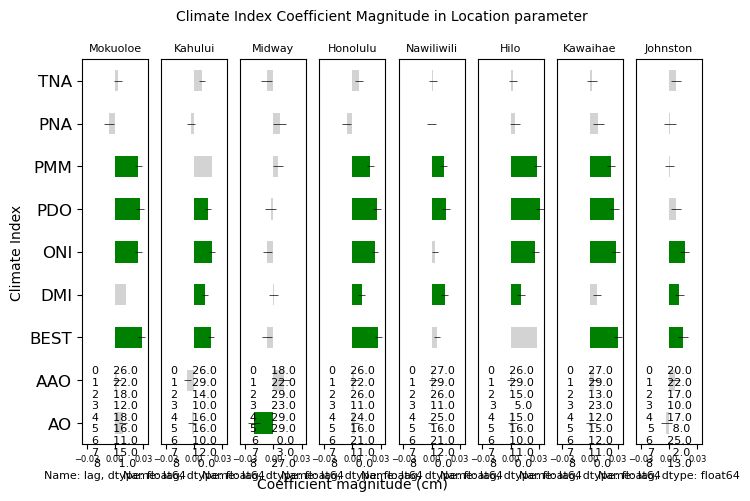

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(1,8,figsize=(8,5))

for i,recordID in enumerate(recordIDs):
     
    station_name = station_names[recordID]
    # Create the full path for the JSON file
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'cvte_location_params_ALL.json'

     # Open and read the JSON file
    with open(jsonpath, 'r') as f:
        output = json.load(f)
    
    df_cvteLocation = pd.DataFrame(output)

    # Define colors based on significance
    location_colors = np.where(df_cvteLocation['Significance (over Nodal)']>0.95, 'green', 'lightgray')


    # Plot the Location parameter with custom colors for significance
    df_cvteLocation.plot(
        x='Climate Index',
        y='CI param',
        kind='barh',  # Horizontal bar plot
        ax=ax[i],
        color=location_colors
    )

    # add error bars
    ax[i].errorbar(df_cvteLocation['CI param'], df_cvteLocation.index, 
                   xerr=df_cvteLocation['Standard Error of CI param'], fmt='none', ecolor='black', capsize=0, lw =0.5)
    
    # add lag to each bar
    ax[i].text(0, 0, str(df_cvteLocation['lag']), fontsize=8, ha='center', va='center', color='black')


    ax[i].legend().set_visible(False)

    # Remove y-axis label
    ax[i].set_ylabel('')

    # remove x-tick labels
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_yticks([])

    # set all axes to the same scale
    ax[i].set_xlim(-0.035,0.035)

    # set xticks to have only 3 ticks
    ax[i].set_xticks(np.linspace(-0.03,0.03,3))

    # set fontsize of xticks
    ax[i].tick_params(axis='x', labelsize=6)
    ax[i].set_title(station_name.split(',')[0].strip(), fontsize=8)

    # add super title
    fig.suptitle('Climate Index Coefficient Magnitude in Location parameter', fontsize=10)

    # add y label to full plot
    ax[0].set_ylabel('Climate Index', fontsize=10)

    # add x label to full plot
    ax[3].set_xlabel('Coefficient magnitude (cm)', fontsize=10, labelpad=10)






#### Plot all models
Next we'll look at all models and how they compare.

Text(0.5, 1.0, 'Return Levels: Honolulu, Hawaii')

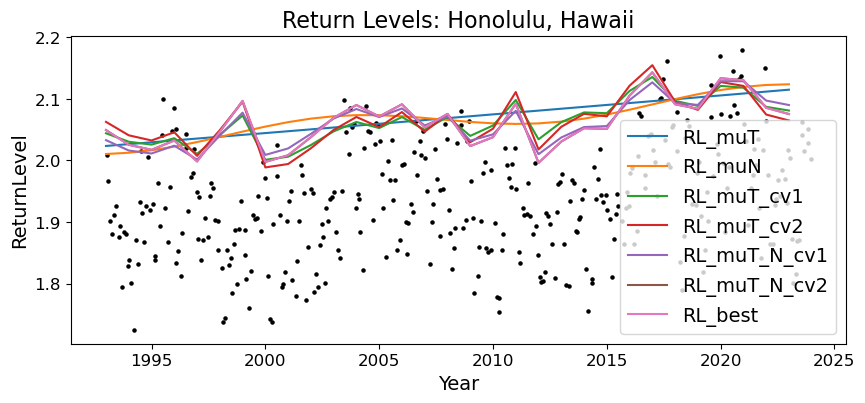

In [6]:
# Only do Honolulu for now
recordID = 57

modelTypes = ['RL_muT', 'RL_muN','RL_muT_cv1','RL_muT_cv2','RL_muT_N_cv1','RL_muT_N_cv2','RL_best']

for modelType in modelTypes:
    modelName = modelType + '.nc'
    modelPath = Path(dirs['model_output_dir'] / str(recordID) / modelName)
    model = xr.open_dataset(modelPath)

    model['ReturnLevel'].sel(ReturnPeriod=2).plot()

plt.legend(modelTypes)

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
with open(jsonpath, 'r') as f:
    output = json.load(f)
    modelInfo = output['modelInfo']
    params = output['w']
    x = output['x']

time = modelInfo['year0'] + pd.Series(modelInfo['t'])
plt.scatter(time, modelInfo['monthlyMax'], color='k', label='Monthly Maxima', s=5)

plt.title('Return Levels: ' + model.attrs['station_name'])



### Plot Components in time
First we'll make a function for plotting.

In [7]:

w = adjust_w_for_plotting(x, params)

def plot_location(w, modelInfo, label, offset=0, component=True):
    # Unpack the w array
    b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
    a0, bLT, bCI, aCI, bN1, bN2 = w[1], w[9], w[10], w[11], w[12], w[13]

    # Check if w[10] (bCI) is zero (i.e., no covariate contribution)
    if bCI == 0:
        ti = np.arange(0, modelInfo['t'][-1], 0.01)
        CI = 0  # Covariate is zero if bCI is zero
    else:
        ti = pd.Series(modelInfo['t']) 
        CI = pd.Series(modelInfo['covariate'])  # Covariate values

        

    # Make sure CI and ti are aligned (if CI is a series)
    if isinstance(CI, pd.Series) and len(CI) != len(ti):
        raise ValueError("Length of covariate CI does not match the length of ti.")

    # Define mut (location(t)) as a function of ti and CI
    mut = (b0 * np.exp(bLT * ti) +
           b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
           b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
           b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
           bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
           (bCI * CI))  

    # Calculate the amplitudes for each harmonic and the covariate
    amp_annual = np.sqrt(b1**2 + b2**2)      # First harmonic (annual cycle)
    amp_semiannual = np.sqrt(b3**2 + b4**2)  # Second harmonic (semiannual cycle)
    amp_third = np.sqrt(b5**2 + b6**2)       # Third harmonic (quarterly or 8π cycle)
    amp_nodal = np.sqrt(bN1**2 + bN2**2)     # Nodal component
    amp_covariate = abs(bCI)                 # Covariate amplitude
    amp_trend = 0.5*(b0 * np.exp(bLT * modelInfo['t'][-1]) - b0*np.exp(bLT * modelInfo['t'][0]))  # Trend amplitude



    amp_seasonal = np.sqrt(amp_annual**2 + amp_semiannual**2 + amp_third**2)
    
    # Calculate the total amplitude
    amp = np.sqrt(amp_seasonal**2 + amp_nodal**2 + amp_covariate**2 + amp_trend**2)
    


    # Subtract the datum offset
    mut = mut - modelInfo['STNDtoMHHW']

    if component:
        mut_demeaned = mut - np.mean(mut)
    else:
        mut_demeaned = mut
    
    # mut_demeaned = mut_demeaned - modelInfo['STNDtoMHHW']
    
    # add zero line for reference in gray
    plt.axhline(y=offset, color='gray', linestyle='-.', alpha=0.5)

    # Plot the result

    plt.plot(ti+modelInfo['year0'], mut_demeaned + offset, label=label + ' (' + str(round(2*amp*100, 2)) + ' cm)') 
    return amp



Then we'll make a function for making the figure.

In [8]:
# Make figure
def make_component_figure(w, modelInfo, model, time):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    returnYear = 10

    # Add 50-year return level to the plot
    plt.plot(model['Year']+0.5, 
            model['ReturnLevel'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
            label=f'{returnYear}-year Return Level', color='black', linewidth=2) 

    # add error bars as shaded area from model['RL_low'] to model['RL_high']
    plt.fill_between(model['Year']+0.5, 
                    model['RL_high'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
                    model['RL_low'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'],
                    color='gray', alpha=0.2)

    # Add monthly maxima, centered
    mm = np.array(modelInfo['monthlyMax']) - modelInfo['STNDtoMHHW']
    plt.scatter(time, mm, color='gray', label='Monthly Maxima', s=5)
    amp_full = plot_location(w, modelInfo, label='Full $\mu(t)$', offset=0, component=False)

    # First plot: Covariate contribution
    wnew = np.zeros(len(w))
    wnew[10] = w[10]  # Only use the covariate component
    offset1 = -0.2  # Offset for the plot
    amp_CI = plot_location(wnew, modelInfo, label=modelInfo['covariateName'] , offset=offset1)


    # Second plot: Seasonal components
    wnew = np.zeros(len(w))
    wnew[1:9] = w[1:9]  # Seasonal components
    offset1 -= 0.2  # Increment offset correctly
    amp_S = plot_location(wnew, modelInfo, label='Seasonal', offset=offset1)

    # Third plot: Long-term trend
    wnew = np.zeros(len(w))
    wnew[9] = w[9]  # Long-term trend component
    wnew[0] = w[0]  # Plus base value
    offset1 -= 0.2  # Increment offset correctly
    amp_LT = plot_location(wnew, modelInfo, label='Long-term trend', offset=offset1)


    # Fourth plot: Nodal component
    wnew = np.zeros(len(w))
    wnew[12:14] = w[12:14]  # Nodal components
    offset1 -= 0.2  # Increment offset correctly
    amp_N = plot_location(wnew, modelInfo, label='Nodal', offset=offset1)

    plt.title('Location Parameter Components: ' + model.attrs['station_name'])
    plt.xlim(modelInfo['t'][0] + modelInfo['year0'], modelInfo['t'][-1] + modelInfo['year0'])
    plt.ylabel('Height above MHHW (m)')

    # Add legend to the outside of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # add a second y-axis on the right side to label components
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(0, offset1-0.2, -0.2))
    ax2.set_yticklabels(['Full $\mu(t)$',
                      modelInfo['covariateName'] + ' $\mu_{CI}(t)$' , 
                      'Seasonal $\mu_{S}(t)$', 
                      'Long-term trend $\mu_{LT}(t)$', 
                      'Nodal $\mu_{N}(t)$']); #not sure why there's output here but I've suppressed it
    
    
    
    
    amps = [amp_full, amp_CI, amp_S, amp_LT, amp_N]
    amp_names = ['Full', 'Covariate', 'Seasonal', 'Long-term trend', 'Nodal']
    amps = dict(zip(amp_names, amps))
    return fig, amps, ax


Finally, we'll plot it up!

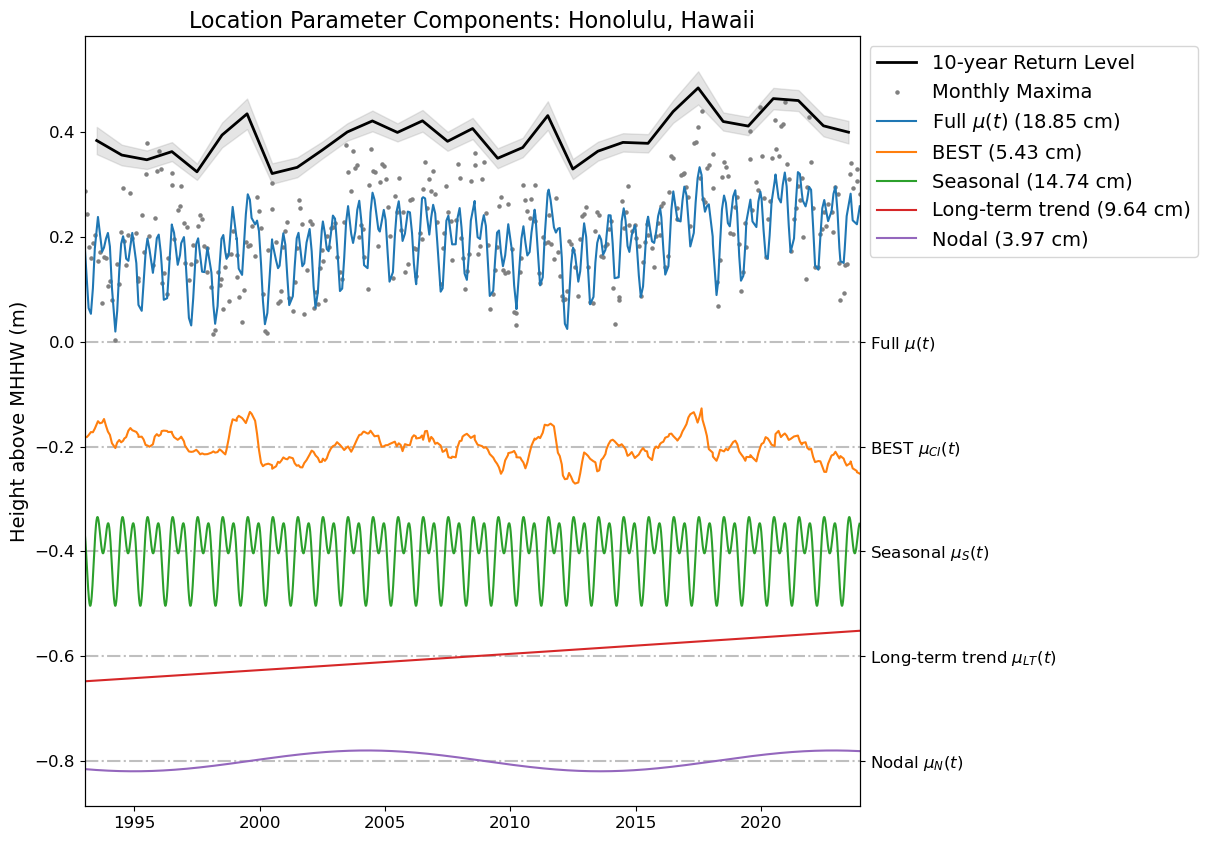

In [9]:
fig, amps, ax = make_component_figure(w, modelInfo, model, time)

#save the figure
savename = 'LocationComponents_' + model.attrs['station_name'] + '.png'
filename = Path(dirs['output_dir']) / savename
fig.savefig(filename, bbox_inches='tight')

Now we'll save the parameter component amplitudes to our model output directory.

In [10]:
# save amps to a json file
amps_json = Path(dirs['model_output_dir']) / str(recordID) / 'location_param_component_amps.json'
with open(amps_json, 'w') as f:
    json.dump(amps, f)

### Plot components by station

The following code can only be run after all gauges have been modeled!

In [11]:
# get all location_parms_component_amp.json files and combine them into one
amps = {}

for recordID in recordIDs:
    amps_json = Path(dirs['model_output_dir']) / str(recordID) / 'location_param_component_amps.json'
    with open(amps_json, 'r') as f:
        amps[recordID] = json.load(f)


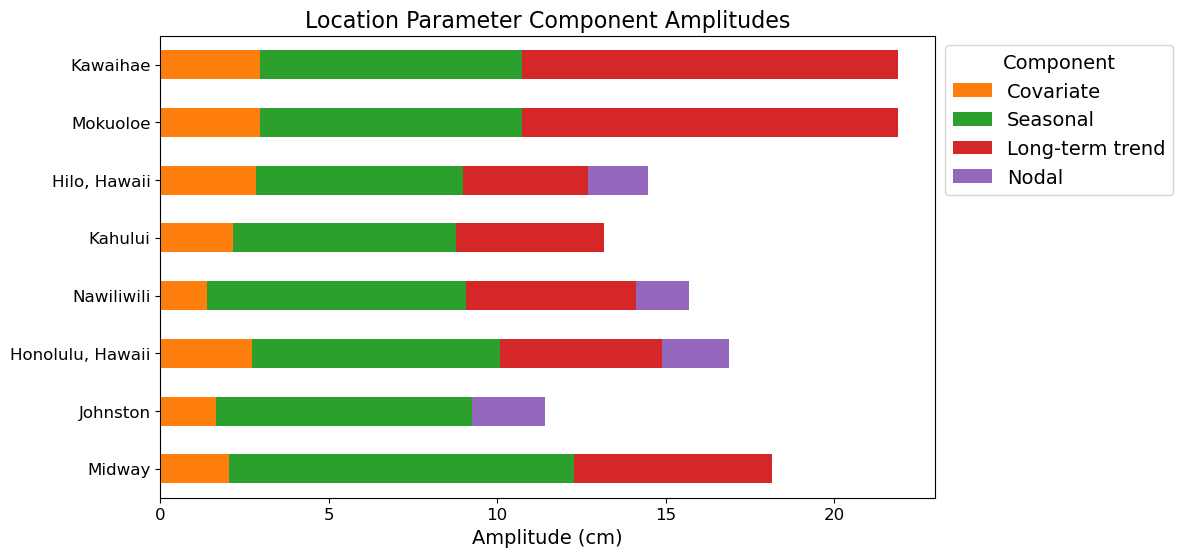

In [12]:
# Plot df as stacked bar chart ignoring the full component
# Turn amps into a dataframe
df = pd.DataFrame(amps).T
df = df.drop('Full', axis=1)

# Reorder columns to match above plot
df = df[['Covariate','Seasonal', 'Long-term trend',  'Nodal']]
df = df.sort_index()

# conver the data colums to cm and round to 2 decimal places
df = df.apply(lambda x: x*100).round(2)

# add station names to the dataframe
df['Station Name'] = station_names.values()


# Plot the data with amplitudes on the x-axis
df.plot(kind='barh', stacked=True, figsize=(10, 6), color=plt.cm.tab10.colors[1:])
plt.title('Location Parameter Component Amplitudes')
plt.xlabel('Amplitude (cm)')
plt.legend(title='Component', loc='upper left', bbox_to_anchor=(1, 1))

# replace the x-axis with the station names
plt.yticks(np.arange(len(df.index)), df['Station Name']);

# save the plot
savename = Path(dirs['output_dir']) / 'location_param_component_amps.png'
plt.savefig(savename, bbox_inches='tight')


### Plot a map


In [13]:
# load rsl data
with xr.open_dataset(dirs['data_dir'] / 'rsl_daily_hawaii.nc') as rsl:
    df = rsl[['lat', 'lon', 'station_name', 'record_id']].to_dataframe().reset_index()
    pass

# Initialize ampCI as a vector of zeros
df['ampCI'] = 0

# Assign ampCI values using the recordID column with vectorization, where possible
df['ampCI'] = df['record_id'].map(lambda rid: amps.get(rid, {}).get('Covariate', 0))

# Initialize modelCI with 'None' as default
df['modelCI'] = 'None'

# Function to get modelCI, with improved error handling
def get_model_ci(record_id):
    fpath = Path(dirs['model_output_dir']) / str(record_id) / 'RL_best.nc'
    try:
        with xr.open_dataset(fpath) as model:
            return model.attrs.get('covariate', 'None')
    except FileNotFoundError:
        print(f'FileNotFoundError: No model found for recordID: {record_id}')
        return 'None'
    except Exception as e:
        print(f'Error processing {record_id}: {e}')
        return 'None'

# Apply the function to the DataFrame (efficient vectorized operation)
df['modelCI'] = df['record_id'].apply(get_model_ci)


FileNotFoundError: No model found for recordID: 14
FileNotFoundError: No model found for recordID: 547
FileNotFoundError: No model found for recordID: 548


In [14]:
df

,record_id,lat,lon,station_name,ampCI,modelCI
0,14,23.867001,193.710007,French Frigate,0.000000,None
1,50,28.216999,182.632996,Midway,0.020382,AO
2,52,16.750000,190.483002,Johnston,0.016530,ONI
3,57,21.306999,202.132996,"Honolulu, Hawaii",0.027141,BEST
4,58,21.966999,200.649994,Nawiliwili,0.013765,DMI
5,59,20.900000,203.533005,Kahului,0.021529,ONI
6,60,19.733000,204.932999,"Hilo, Hawaii",0.028262,PMM
7,61,21.433001,202.199997,Mokuoloe,0.029631,BEST
8,547,21.322001,201.880005,"Barbers Point, HI",0.000000,None
9,548,20.783001,203.000000,"Kaumalapau, HI",0.000000,None


In [15]:
df['ampCI'] = 100*df['ampCI']
df['ampCI'] = df['ampCI'].round(2)

# make all ampCI values if zero 0.05
df['ampCI'] = df['ampCI'].replace(0, 0.3)

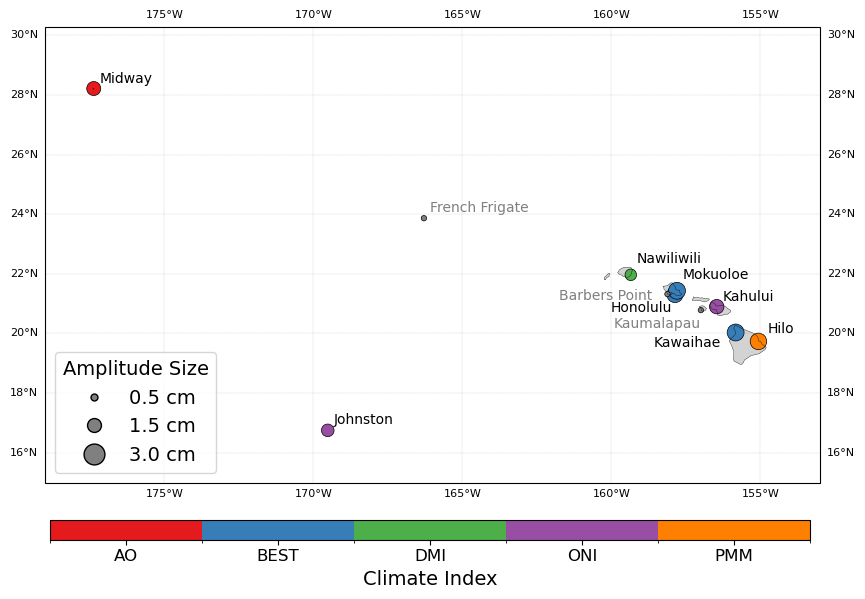

In [16]:
# Separate the "None" entries from the rest of the data
df_none = df[df['modelCI'] == 'None']  # Entries where modelCI is 'None'
df_filtered = df[df['modelCI'] != 'None']  # All other entries

# Use tab10 colormap for colors (excluding 'None')
cmap = plt.get_cmap('Set1')
color_dict = {index: cmap(i) for i, index in enumerate(np.unique(df_filtered['modelCI']))}

# Map the climate indices to numerical values for the colorbar
index_mapping = {index: i for i, index in enumerate(np.unique(df_filtered['modelCI']))}
mapped_indices = [index_mapping[ci] for ci in df_filtered['modelCI']]

# Create a colormap without "None"
norm = colors.BoundaryNorm(boundaries=np.arange(len(np.unique(df_filtered['modelCI'])) + 1) - 0.5, 
                               ncolors=len(np.unique(df_filtered['modelCI'])))

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# # Call plot_thin_map_hawaii to create the figure and axis
plot_thin_map_hawaii(ax)

# Plot each station with varying color (based on climate index) and size (based on amplitude)
scatter = ax.scatter(df_filtered['lon'], df_filtered['lat'], 
                     c=mapped_indices, cmap=cmap, 
                     norm=norm, s=50 * df_filtered['ampCI'],
                     edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

# Plot the "None" stations in gray (fixed color)
ax.scatter(df_none['lon'], df_none['lat'], 
           color='gray', s=50 * df_none['ampCI'], 
           edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

dfInfo = get_stationinfo(dirs['data_dir'])
dfInfo['record_id'] = dfInfo['record_id']

#change the font color to black if the station is in the df_filtered
dfInfo['fontcolor'] = np.where(dfInfo['record_id'].isin(df_filtered['record_id']), 'black', 'gray')

# Add an axes for the colorbar
cax = fig.add_axes([0.13, 0.21, 0.76, 0.02])  

# dfInfo
# Add text labels with adjusted offsets and horizontal alignment
for i, name in enumerate(dfInfo['station_name']):
    ax.text(dfInfo['lon'][i] + dfInfo['offsetlon'][i], dfInfo['lat'][i] + dfInfo['offsetlat'][i], name, 
            ha=dfInfo['ha'][i], fontsize=10, transform=ccrs.PlateCarree(),rotation=0, color = dfInfo['fontcolor'][i])

# Add a colorbar for the climate index
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
cbar.set_ticks(np.arange(len(np.unique(df_filtered['modelCI']))))
cbar.set_ticklabels(np.unique(df_filtered['modelCI']))
cbar.set_label('Climate Index')


# Amplitude size legend
sizes = [50, 100, 150]
size_labels = ["0.5 cm", "1.5 cm", "3.0 cm"]  
size_legend_elements = [Line2D([0], [0], marker='o', color='none', label=label, 
                               markerfacecolor='gray', markersize=size / 10) 
                        for size, label in zip(sizes, size_labels)]
ax.legend(handles=size_legend_elements, title="Amplitude Size", loc="lower left")

# save the figure
savename = Path(dirs['output_dir']) / 'SL_contributions_map.png'
plt.savefig(savename, dpi=300, bbox_inches='tight')
